# Spectral Delay

In [2]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [3]:
#sd.play(data, fs)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_76177/3490877524.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_76177/3490877524.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits


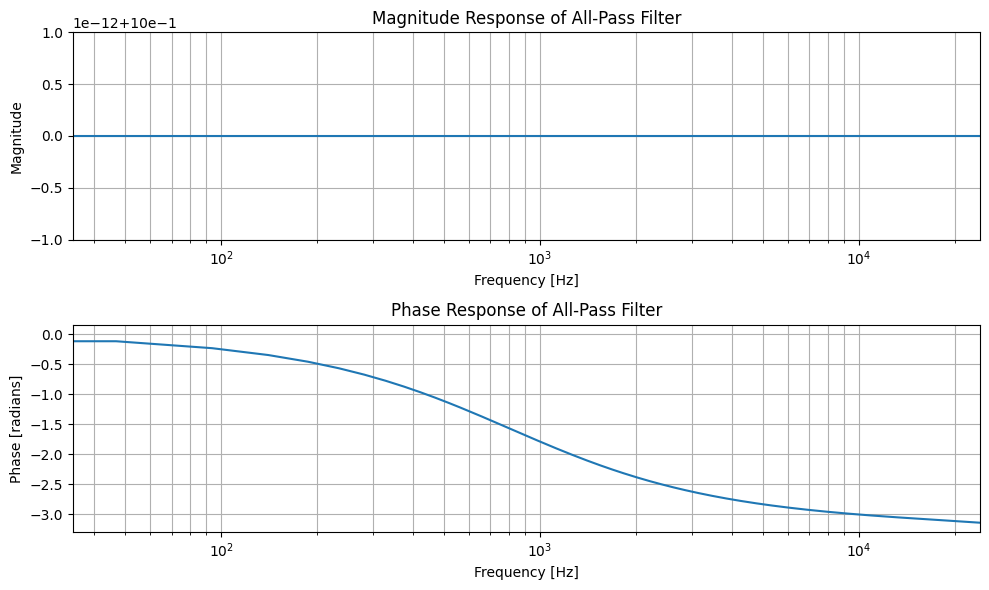

In [4]:
# Allpass Coefficients
a1 = -0.9
num = [a1, 1]
den = [1, a1]

w1, H1 = signal.freqz(num, den)

# Convert frequencies to Hz
freq_hz = w1 * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz, np.abs(H1))
plt.title('Magnitude Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits


plt.subplot(2, 1, 2)
plt.plot(freq_hz, np.angle(H1))
plt.title('Phase Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits


plt.tight_layout()
plt.show()

In [5]:
# Processing Loop
M = 2000 #Number of cascading allpass filters, 2000 gives a very strong effect

dataCpyL = data[:,0]
dataCpyR = data[:,1]

for i in range(1, M):
    data_filtL = signal.lfilter(num, den, dataCpyL)
    data_filtR = signal.lfilter(num, den, dataCpyR)
    dataCpyL = data_filtL
    dataCpyR = data_filtR

stereoFiltered = np.vstack((dataCpyL, dataCpyR))
stereoFiltered = np.transpose(stereoFiltered) 


In [6]:
sd.play(stereoFiltered, fs)

In [7]:
#Write to wav file
#sf.write('SpectralDelay_75APF_ATF.wav', stereoFiltered, fs)

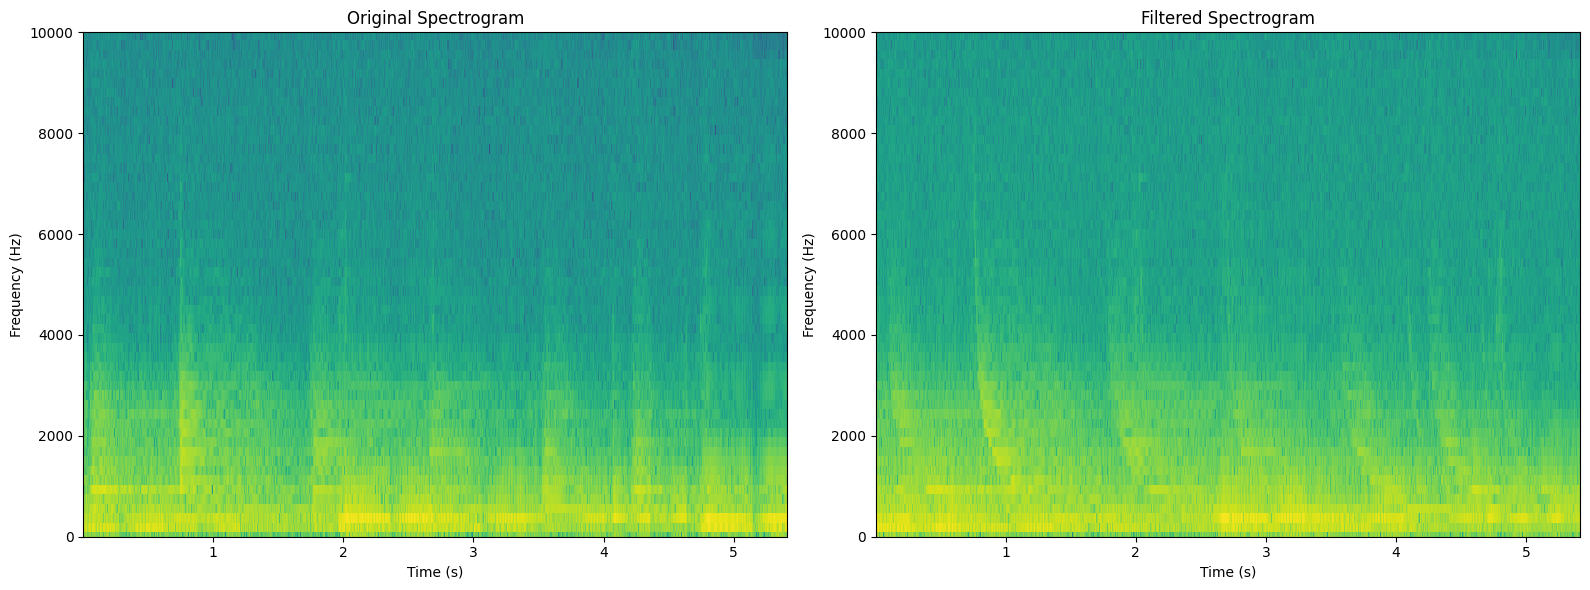

In [14]:
# Compute the spectrogram
frequencies0, times0, Sxx0 = signal.spectrogram(data[40000:300000,0], fs)
# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(stereoFiltered[40000:300000,0], fs)

# Plot the figures side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the original spectrogram
axs[0].pcolormesh(times0, frequencies0, 10 * np.log10(Sxx0), shading='auto')
axs[0].set_title('Original Spectrogram')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_ylim(0, 10000)
axs[0].set_aspect('auto')
#axs[0].set_colorbar(label='Power/Frequency (dB/Hz)')

# Plot the filtered spectrogram
axs[1].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
axs[1].set_title('Filtered Spectrogram')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_ylim(0, 10000)
axs[1].set_aspect('auto')
#axs[1].set_colorbar(label='Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()